In [1]:
# imports 
import tensorflow as tf
import numpy as np
import pandas as pd
import tensorflow.keras.backend as kb
import matplotlib.pyplot as plt
import time
seed = 1
np.random.seed(seed)

# from matplotlib.font_manager import FontProperties
# from matplotlib.ticker import MaxNLocator
# import matplotlib
# fontP = FontProperties()
# fontP.set_size('xx-small')
# matplotlib.rcParams['mathtext.fontset'] = 'stix'
# matplotlib.rcParams['font.family'] = 'STIXGeneral'
# plt.rcParams['grid.alpha'] = 0.5
# plt.rc('grid', linestyle="--", color='grey')
# matplotlib.pyplot.title(r'ABC123 vs $\mathrm{ABC123}^{123}$');
# figsize = (12,8)


plt.rcParams['figure.figsize'] = (12,8)
plt.rcParams['figure.dpi'] = 80

In [2]:
hidden_u = []
m = 200
dim = 2
bounds = [1.6, 4]
n = 90


In [31]:
def get_regularised_bn_mlp(input_shape, m, hidden_units, l2_reg_coeff = None, dropout_rate = None):
    """
    This function is used to build the MLP model. It takes input_shape and hidden_units
    as arguments, which should be used to build the model as described above, using the
    functional API.
    Your function should return the model.
    """
    inputs = tf.keras.layers.Input(shape=(input_shape,), name = 'state')
    # h = inputs
    h = tf.keras.layers.Dense(m, activation=tf.math.cos, 
                              kernel_initializer=tf.random_normal_initializer,
                              bias_initializer= tf.random_uniform_initializer(0, 2*  np.pi), 
                              trainable=False, name = '1st_hidden')(inputs)
    # h = np.sqrt(2) * h 
    for units in hidden_units:
        h = tf.keras.layers.Dense(units, activation='linear')(h)
    # use bias is false because the derivative of a constant number (bias) is just zero
    outputs = tf.keras.layers.Dense(1, kernel_initializer = tf.zeros_initializer(),activation=None, name = 'output_layer', use_bias=False, trainable=True)(h)
    outputs = outputs / m 
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
    return model

model = get_regularised_bn_mlp(input_shape=dim, m = m, hidden_units= hidden_u)
model.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 state (InputLayer)          [(None, 2)]               0         
                                                                 
 1st_hidden (Dense)          (None, 200)               600       
                                                                 
 output_layer (Dense)        (None, 1)                 200       
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 1)                0         
 da)                                                             
                                                                 
Total params: 800
Trainable params: 200
Non-trainable params: 600
_________________________________________________________________


In [32]:
# def kernel(x, y):
#     # x and y are two dimensional
#     intermediate_output = tf.keras.Model(model.input, model.get_layer('1st_hidden').output)
#     phi_x = intermediate_output(x)
#     phi_y = intermediate_output(y)
#     kernel_xy = phi_x * phi_y
#     return kernel_xy

# my_kernel = np.empty((n,n))

# xs = np.zeros((n,dim))
# ys = np.array([np.random.uniform(-bounds[0], bounds[0],n), np.random.uniform(-bounds[1],bounds[1],n)]).T

# for ind1, i in enumerate(xs):
#     i = i[tf.newaxis, ...]
#     for ind2, j in enumerate(ys):
#         # print(i[tf.newaxis, ...])
#         # print(j.reshape((1,2)))
#         j = j[tf.newaxis, ...]
#         # print(i.shape)
#         # print(j.shape)
#         # print(kernel(i[tf.newaxis, ...],j.reshape((1,2))))
#         # print(kernel(i,j).shape)
#         # print('----')
#         my_kernel[ind1, ind2] = kernel(i,j)
# my_kernel


In [33]:
x = np.linspace(-bounds[0], bounds[0], n)
y = np.linspace(-bounds[1], bounds[1], n)

# x = np.linspace(-1, bounds[0], numpoints)
# y = np.linspace(-1, bounds[1], numpoints)

X, Y = np.meshgrid(x, y)

s = X.shape

Ze = np.zeros(s)
Zp = np.zeros(s)
DT = np.zeros((n**2,dim))

# convert mesh into point vector for which the model can be evaluated
c = 0
for i in range(s[0]):
    for j in range(s[1]):
        DT[c,0] = X[i,j]
        DT[c,1] = Y[i,j]
        c = c+1;
# DT

In [34]:
# trial_data = np.array([np.random.uniform(-bounds[0], bounds[0],n), np.random.uniform(-bounds[1],bounds[1],n)]).T

trial_data = np.array([np.linspace(-1.6,1.6, n),np.linspace(-4,4, n)]).T

intermediate_output1 = tf.keras.Model(model.input, model.get_layer('1st_hidden').output)
phi_0 = intermediate_output1(tf.zeros((n, dim)))
phi_0 = phi_0[0]
# phi_0

In [35]:
intermediate_output2 = tf.keras.Model(model.input, model.get_layer('1st_hidden').output)
# phi_y = intermediate_output2(trial_data)
phi_y = intermediate_output1(DT)
# phi_y

# Zp = np.zeros(s)
# c = 0
# for i in range(s[0]):
#     for j in range(s[1]):
#         print(phi_y[c].shape)
#         Zp[i,j] = phi_y[c]
#         c = c+1;
phi_y.shape

TensorShape([8100, 200])

In [36]:
# # this is the inner product (nope)
# inn_p = phi_0 * phi_y

# all1 = tf.tensordot(inn_p, tf.transpose(inn_p), 1)
all1 = tf.tensordot(phi_y, phi_0, 1)
# print(all1)
# all1, all2 = np.array(np.meshgrid(all1, all1))
all1

<tf.Tensor: shape=(8100,), dtype=float32, numpy=
array([102.775894, 102.79186 , 102.80749 , ...,  99.34978 ,  99.33746 ,
        99.32483 ], dtype=float32)>

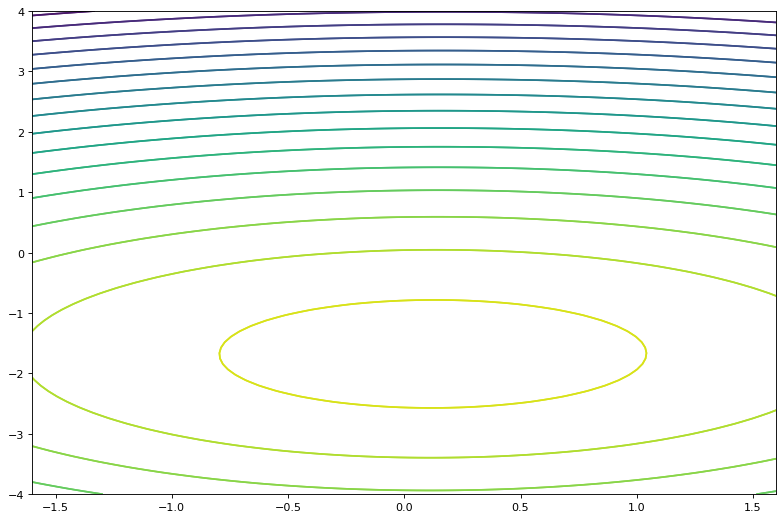

In [37]:
all2 = tf.reshape(all1, (n, n))

plt.contour(trial_data[:,0],trial_data[:,1], all2, levels=15)
plt.contour(x,y, all2, levels=15)

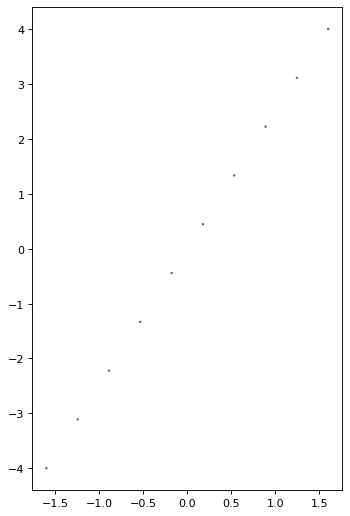

In [94]:
XX,YY = np.meshgrid(trial_data[:,0],trial_data[:,1])
fig = plt.figure(figsize=(5, 8))
plt.scatter(trial_data[:,0], trial_data[:,1],all1)

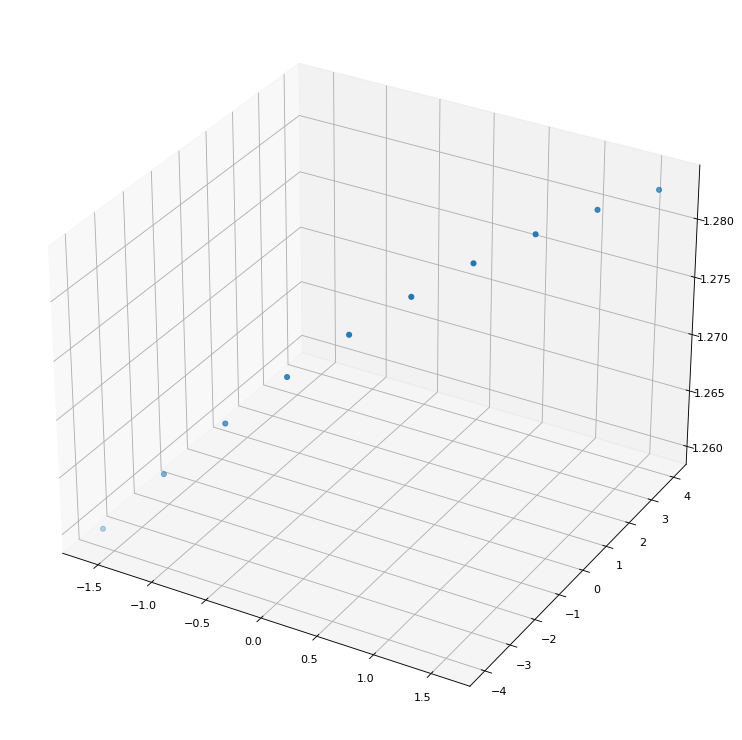

In [95]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')

ax.scatter(trial_data[:,0],trial_data[:,1], all1)
plt.show()

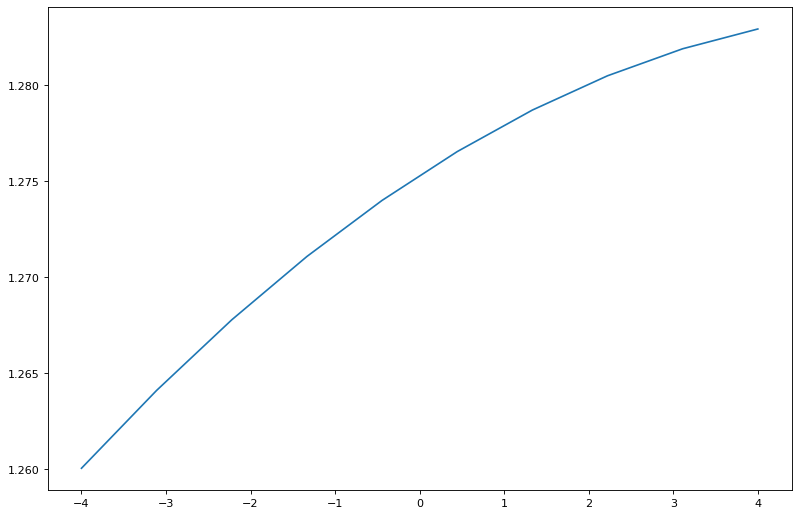

In [96]:
plt.plot(trial_data[:,1], all1)

In [97]:
K_trial = tf.tensordot(phi_0, tf.transpose(phi_y), axes = 1)

TypeError: Input z must be 2D, not 1D

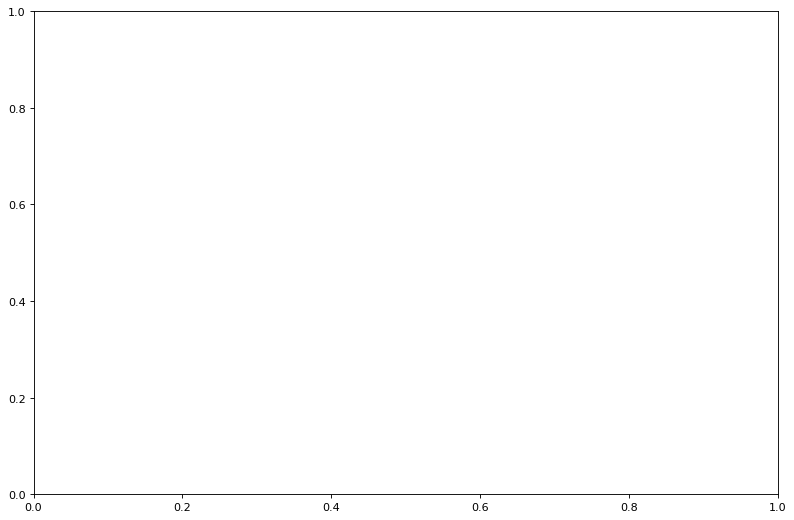

In [98]:
x = np.linspace(-4,4, n)
plt.contour(trial_data[:,0], trial_data[:,1], K_trial)
# plt.contour(x, x, K_trial)